 ### Load the drive containing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Defining function to group less represented parties under the 'Others' category

In [3]:
def creating_category_others(data):
  # Using 0.99 quantile to categorize 'Others'
  threshold_value = data['count'].quantile(0.99)
  values_below_thresh = data['count'] < threshold_value
  data.loc[values_below_thresh,'Label'] = 'Others'
  return data

## Loading datasets

In [4]:
# Load dataset containing sport quotes
dataset = pd.read_csv('/content/drive/MyDrive/ADA/ada-sports-quotes/sport-quotes-2019.csv.bz2', compression='bz2', usecols=['speaker','qids','quoteID'])

# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet', columns=['nationality','party','id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [5]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
dataset['qids'] = dataset['qids'].str.strip('[\'\']')
speakers = speaker_attributes[speaker_attributes['id'].isin(dataset['qids'])]

# Removing speakers without any known party (i.e. with 'party' == None)
politicians = speakers[~(speakers['party'].isna())]

## Computing the number of speakers per party from sport quotes

Only keeping the first qid for the 'party' feature. It is known, that it is not correct because we should select the party in which the speaker was at the time of the quote. This will be solved for Milestone 3, as this requires new speaker_features dataset to obtain this information. 

In [6]:
# Only keeping the first qid in the 'party' feature (with str.get(0))
# Counts the occurences of each party and adding the corresponding party label by merging qid_labels
party_speaker_counts_label = pd.DataFrame(pd.value_counts(politicians['party'].str.get(0))).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the 0.99 quantile to 'Others'
party_speaker_counts_label = creating_category_others(party_speaker_counts_label)

## Computing the number of quotes per party from sport quotes

In [7]:
# Selecting quotes from a speaker with a party and merging the speaker_attributes dataset
dataset_politicians_attributes = dataset[dataset['qids'].isin(politicians['id'])].merge(speaker_attributes, left_on='qids', right_on='id')
# Only keeping the first qid in the 'party' feature (with str.get(0))
dataset_politicians_attributes['party'] = dataset_politicians_attributes['party'].str.get(0)

# Counts the occurences of each party and add the corresponding party label 
party_quotes_counts_label = pd.DataFrame(pd.value_counts(dataset_politicians_attributes['party'])).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the 0.99 quantile to 'Others'
party_quotes_counts_label = creating_category_others(party_quotes_counts_label)

## Plots : pie plots and bar plots

Speaker's party distribution

Text(0.6, 0.92, "Speaker's party distribution of sport quotes for year 2019")

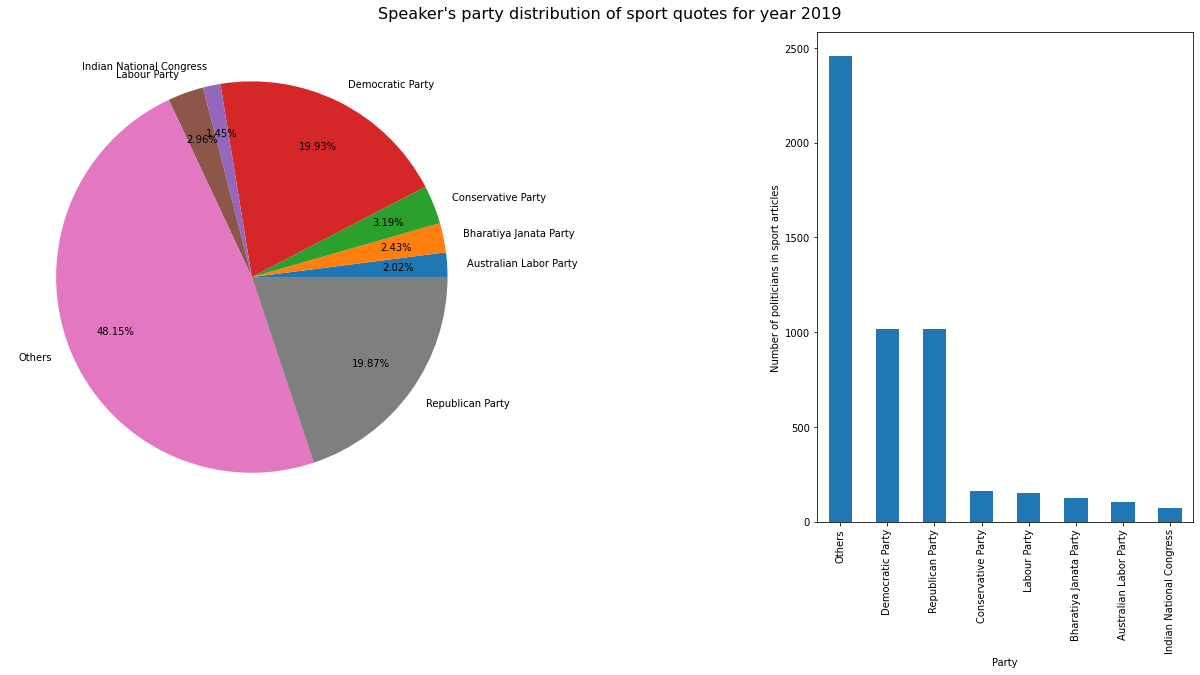

In [8]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_speaker_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0], pctdistance=0.75, ylabel='')
party_speaker_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1], ylabel='Number of politicians in sport articles', xlabel='Party')

plt.subplots_adjust(wspace=0)
fig.suptitle('Speaker\'s party distribution of sport quotes for year 2019', fontsize=16, x=0.6, y=0.92)

Quote's party distribution

Text(0.6, 0.92, "Quote's party distribution of sport quotes for year 2019")

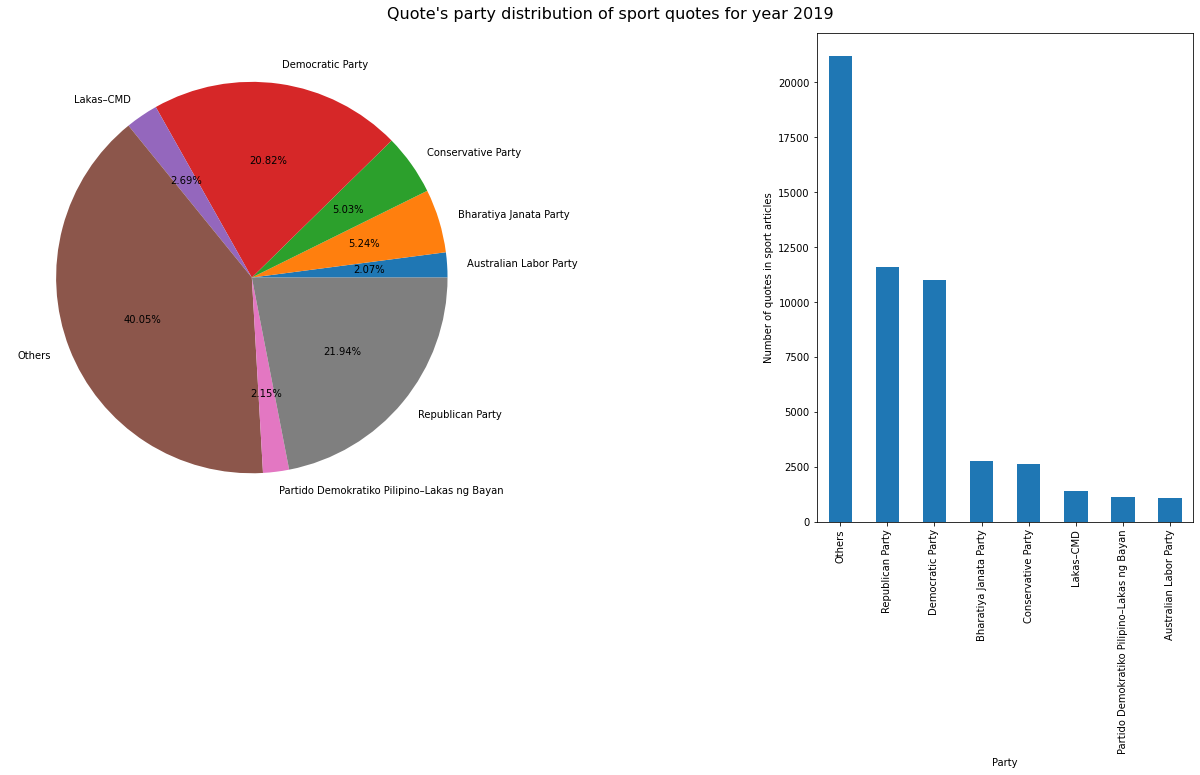

In [9]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_quotes_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0], ylabel='')
party_quotes_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1], ylabel='Number of quotes in sport articles', xlabel='Party')

plt.subplots_adjust(wspace=0)
fig.suptitle('Quote\'s party distribution of sport quotes for year 2019', fontsize=16, x=0.6, y=0.92)

## Data description and overview

Lengths of DataFrame (i.e. number of sample)

In [10]:
print('Number of sport quotes: {q_sport}\nNumber of political quotes: {q_pol}\nNumber of speakers: {spea}\nNumber of politicians (i.e. speakers with political party): {pol}\nNumber of different parties: {part}'\
      .format(q_sport=dataset.shape[0], spea=speakers.shape[0], pol=politicians.shape[0], part=party_speaker_counts_label.shape[0], q_pol=dataset_politicians_attributes.shape[0]))

Number of sport quotes: 2922983
Number of political quotes: 52910
Number of speakers: 64583
Number of politicians (i.e. speakers with political party): 5107
Number of different parties: 667


In [11]:
dataset.sample(5)

,quoteID,speaker,qids
2533899,2019-01-12-021834,Chris Mullin,"Q289398', 'Q5107532"
1215754,2019-04-07-021853,None,
302690,2019-10-29-042097,Aoife Walsh,Q45033308
2165910,2019-02-02-031421,None,
1576788,2019-11-30-014785,Dean Smith,"Q1181130', 'Q1181132', 'Q18171697', 'Q202584',..."


In [12]:
speakers.sample(5)

,nationality,party,id
1327664,[Q30],None,Q7282066
345199,[Q30],None,Q19609702
5688153,[Q16],None,Q768157
8478766,[Q766],None,Q56091630
206410,[Q30],None,Q7819118


In [13]:
politicians.sample(5)

,nationality,party,id
301154,[Q30],[Q29468],Q16213675
4855240,[Q30],[Q29552],Q18045052
5798909,[Q30],[Q29552],Q5180849
2436481,[Q30],[Q29468],Q6200312
3424561,[Q145],"[Q3179541, Q9630]",Q727460


In [14]:
party_speaker_counts_label.head(5)

,count,Label,Description
QID,,,
Q29552,1018,Democratic Party,political party in the United States
Q29468,1015,Republican Party,major political party in the United States
Q9626,163,Conservative Party,political party in the United Kingdom
Q9630,151,Labour Party,political party in the United Kingdom
Q10230,124,Bharatiya Janata Party,major political party in India


In [15]:
dataset_politicians_attributes.sample(5)

,quoteID,speaker,qids,nationality,party,id
20379,2019-06-21-005757,Mashrafe Mortaza,Q3350076,[Q902],Q1281480,Q3350076
28811,2019-10-08-040168,Salvador Panelo,Q25999502,None,Q2597155,Q25999502
47540,2019-12-11-107110,Peter Beuth,Q1536219,[Q183],Q49762,Q1536219
25441,2019-06-25-083904,Jeff Morris,Q6174560,[Q30],Q29552,Q6174560
20991,2019-08-25-039882,Narendra Modi,Q1058,[Q668],Q10230,Q1058


In [16]:
party_quotes_counts_label.head(5)

,count,Label,Description
QID,,,
Q29468,11610,Republican Party,major political party in the United States
Q29552,11017,Democratic Party,political party in the United States
Q10230,2775,Bharatiya Janata Party,major political party in India
Q9626,2662,Conservative Party,political party in the United Kingdom
Q6474567,1424,Lakas–CMD,political party in the Philippines
